# Bank Personal Loan Modelling

This is part-1 of a case study exercise based on what we learned in Supervised Learning Residency Class in July 2018.

### Case study:

This case is about a bank (Thera Bank) which has a growing customer base. Majority of these customers are liability customers (depositors) with varying size of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors). A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio with minimal budget. The department wants to build a model that will help them identify the potential customers who have higher probability of purchasing the loan. This will increase the success ratio while at the same time reduce the cost of the campaign. The file Bank.xls contains data on 5000 customers. The data include customer demographic information (age, income, etc.), the customer's relationship with the bank (mortgage, securities account, etc.), and the customer response to the last personal loan campaign (Personal Loan). Among these 5000 customers, only 480 (= 9.6%) accepted the personal loan that was offered to them in the earlier campaign.

### Steps Involved:

1. Data pre-processing - Understand the data and treat missing values, outliers

2. Understanding the attributes - Find relationship between different attributes (Independent variables) and choose carefully which all attributes have to be a part of the analysis and why 

3. Model the data using Logistic regression

4. Find the accuracy of the model using confusion matrix

5. Use K - NN model [Hint: Try different values of k] and compare the accuracy of this model with that of Logistic regression

### Data & Objectives:

File Bank_Personal_Loan_Modelling.xlsx is provided.

#### Project Objectives:
While designing a new campaign, can we model the previous campaign's customer behavior to analyze what combination of parameters make a customer more likely to accept a personal loan?

There are several special products / facilities the bank offers like CD and security accounts, online services, credit cards, etc. Can we spot any association among these for finding cross-selling opportunities?

#### Data Description:
```
ID                  Customer ID                                                                  UnsignedNumber
Age                 Customer's age in years                                                      UnsignedNumber
Experience          Years of professional experience                                             UnsignedNumber
Income              Annual income of the customer                                                Float64
ZIPCode 	        Home Address ZIP code                                                        Categorical
Family              Family size of the customer                                                  UnsignedNumber
CCAvg               Avg. spending on credit cards per month                                      Float64
Education           Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional         Categorical
Mortgage            Value of house mortgage if any.                                              Float64
Personal Loan       Did this customer accept the personal loan offered in the last campaign?     Boolean(1,0)
Securities Account  Does the customer have a securities account with the bank?                   Boolean(1,0)
CD Account          Does the customer have a certificate of deposit (CD) account with the bank?  Boolean(1,0)
Online              Does the customer use internet banking facilities?                           Boolean(1,0)
CreditCard          Does the customer use a credit card issued by the bank?                      Boolean(1,0)
```
*Note: Data is hypothetical*

# Import Required Libraries Here

In [740]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import zscore
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

# Data Pre-Processing

## Read Excel File

In [741]:
# Use read_excel method of Pandas Dataframe to read the data from the spreadsheet
# Note that in the SpreadSheet, there are two sheets:
# 1. README
# 2. Bank_Personal_Loan_Modelling Sheet. This is the sheet that has the data, hence we need to read only this sheet
# Kindly note for some reason the Family Members data type can't be changed to Int while reading, hence using float

bpl_data = pd.read_excel("Bank_Personal_Loan_Modelling.xlsx", 
                         sheet_name='Bank_Personal_Loan_Modelling', 
                         index_col=0,
                         dtype={'Age (in years)':np.int8,'Experience (in years)':np.int8, 
                                'Income (in K/month)':np.int32, 'ZIP Code':'category', 'Family members':np.float16,
                                'CCAvg':np.float32, 'Education':np.int8, 'Mortgage': np.int32, 
                                'Personal Loan':np.int8, 'Securities Account':np.int8, 
                                'CD Account':np.int8, 'Online':np.int8, 'CreditCard':np.int8},
                         names=['Age','Experience','Income','ZIPCode','Family','CCAvg',
                                  'Education','Mortgage','PersonalLoan','SecuritiesAccount','CDAccount',
                                  'NetBanking','CreditCard'])
bpl_data.head()

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,NetBanking,CreditCard
ID,,,,,,,,,,,,,
1,25,1,49,91107,4.0,1.6,1,0,0,1,0,0,0
2,45,19,34,90089,3.0,1.5,1,0,0,1,0,0,0
3,39,15,11,94720,1.0,1.0,1,0,0,0,0,0,0
4,35,9,100,94112,1.0,2.7,2,0,0,0,0,0,0
5,35,8,45,91330,4.0,1.0,2,0,0,0,0,0,1


## Verify the Data Types

*Kindly Note that categorical data types are already labelled numerically, hence imported that with numeric data type*  
*ZIPCode is the only one that is imported as categorical*

In [742]:
# Verify the data types before we proceed further
bpl_data.dtypes

Age                      int8
Experience               int8
Income                  int32
ZIPCode              category
Family                float16
CCAvg                 float32
Education                int8
Mortgage                int32
PersonalLoan             int8
SecuritiesAccount        int8
CDAccount                int8
NetBanking               int8
CreditCard               int8
dtype: object

## Find the Missing Values

In [743]:
# Is there any Missing Values ?
bpl_data.isnull().values.any()

True

In [744]:
# Print the rows that has missing values
bpl_data[bpl_data.isnull().any(axis=1)]

# Observations
# Only Family Members Column has missing values and 18 rows has missing values

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,NetBanking,CreditCard
ID,,,,,,,,,,,,,
21,56,31,25,94015,NaN,0.9,2,111,0,0,0,1,0
59,28,2,93,94065,NaN,0.2,1,0,0,0,0,0,0
99,49,23,94,92374,NaN,0.3,1,0,0,0,0,1,0
162,61,35,80,95053,NaN,2.8,1,0,0,0,0,1,0
236,38,8,71,94720,NaN,1.8,3,0,0,0,0,1,0
290,42,15,24,92121,NaN,1.0,2,0,0,0,0,1,1
488,39,13,88,94117,NaN,1.4,2,0,0,0,0,1,1
722,49,24,39,92717,NaN,1.4,3,0,0,0,0,1,0
1461,40,16,85,92677,NaN,0.2,3,0,0,0,0,1,1


## Fill the missing values

*Kindly note only Family column has missing values*  
*The total number of rows that contains missing values is 18*
  
Identify the Mean, Median of the Family Column   
Fill the missing values with Mean or Median based on which ever is appropriate  

In [745]:
# Describe the statistics in the dataframe
stats_desc = bpl_data.describe().transpose()
stats_desc

,count,mean,std,min,25%,50%,75%,max
Age,5000.0,45.338400,11.463166,23.0,35.0,45.0,55.0,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.0,20.0,30.0,43.0
Income,5000.0,73.774200,46.033729,8.0,39.0,64.0,98.0,224.0
Family,4982.0,2.396484,1.146484,1.0,1.0,2.0,3.0,4.0
CCAvg,5000.0,1.937932,1.747658,0.0,0.7,1.5,2.5,10.0
Education,5000.0,1.881000,0.839869,1.0,1.0,2.0,3.0,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.0,0.0,101.0,635.0
PersonalLoan,5000.0,0.096000,0.294621,0.0,0.0,0.0,0.0,1.0
SecuritiesAccount,5000.0,0.104400,0.305809,0.0,0.0,0.0,0.0,1.0
CDAccount,5000.0,0.060400,0.238250,0.0,0.0,0.0,0.0,1.0


In [746]:
# Number of Family Members will be always a whole number and it ranges from 1 to 4 in the dataset
# Fill the missing values in Family Members attribute with the median of the overall statistics. 
# Median will be good here as the number of possibilities is small
bpl_data['Family'].fillna((bpl_data['Family'].median()),inplace=True)
# Check whether there is any more missing values
bpl_data.isnull().values.any()

False

In [747]:
# Pick randomly any missing value row and check whether the median value is populated 
bpl_data.loc[722]

Age                     49
Experience              24
Income                  39
ZIPCode              92717
Family                   2
CCAvg                  1.4
Education                3
Mortgage                 0
PersonalLoan             0
SecuritiesAccount        0
CDAccount                0
NetBanking               1
CreditCard               0
Name: 722, dtype: object

## Understand the attributes of consumers who took Personal Loan

In [748]:
# First lets filter the consumers who accepted personal loan
bpl_pld = bpl_data[bpl_data['PersonalLoan']==1]
# Lets understand the statistics of numeric independant variables
bpl_pld.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,480.0,45.066667,11.590964,26.0,35.0,45.0,55.0000,65.0
Experience,480.0,19.843750,11.582443,0.0,9.0,20.0,30.0000,41.0
Income,480.0,144.745833,31.584429,60.0,122.0,142.5,172.0000,203.0
Family,480.0,2.611328,1.112305,1.0,2.0,3.0,4.0000,4.0
CCAvg,480.0,3.905352,2.097681,0.0,2.6,3.8,5.3475,10.0
Education,480.0,2.233333,0.753373,1.0,2.0,2.0,3.0000,3.0
Mortgage,480.0,100.845833,160.847862,0.0,0.0,0.0,192.5000,617.0
PersonalLoan,480.0,1.000000,0.000000,1.0,1.0,1.0,1.0000,1.0
SecuritiesAccount,480.0,0.125000,0.331064,0.0,0.0,0.0,0.0000,1.0
CDAccount,480.0,0.291667,0.455004,0.0,0.0,0.0,1.0000,1.0


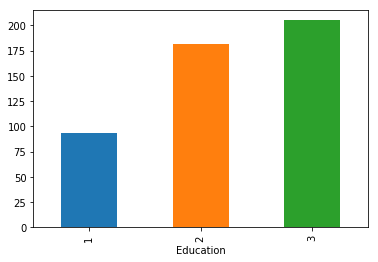

In [749]:
bpl_pld.groupby('Education').size().plot(kind='bar')

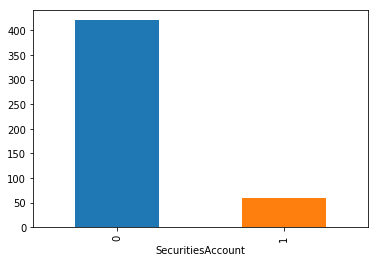

In [750]:
bpl_pld.groupby('SecuritiesAccount').size().plot(kind='bar')

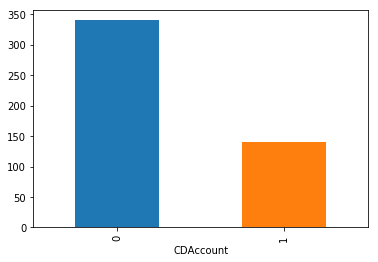

In [751]:
bpl_pld.groupby('CDAccount').size().plot(kind='bar')

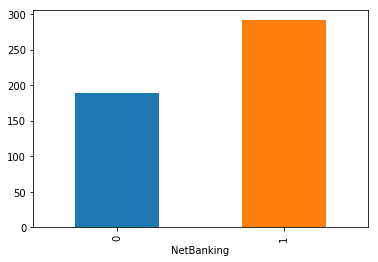

In [752]:
bpl_pld.groupby('NetBanking').size().plot(kind='bar')

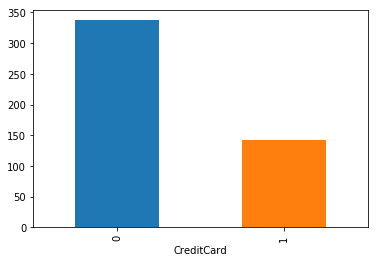

In [753]:
bpl_pld.groupby('CreditCard').size().plot(kind='bar')

## Statistical Findings of the consumers who took the Personal Loan

Total consumers who accepted personal loan = 480  
Their average experience level = 19.8  
Their average age is 45  
Their average income is 144.75K  
Their average family size is 3  
Their average spending on credit card is 3.9K  
Their average mortgage is 100.8K  
~43% of them completed Advanced/Professional Education  
~87.5% of them don't have securities account  
~71% of them don't have CD Account  
~61% of them use Internet Banking facility  
~70% of them don't hold credit card  

## Find the Outliers in the data

In [754]:
# Calculate InterQuartile Range to find outliers
# IQR = Q3 - Q1 (75% - 25%)
# Left Tail Whisker = Q1 - 1.5*IQR = 25% - 1.5*IQR
# Right Tail Whisker = Q3 - 1.5*IQR = 75% - 1.5*IQR
# Outliers: Values < Left Tail Whisker and Values > Right Tail Whisker
stats_desc['1.5IQR'] = stats_desc['75%'] - stats_desc['25%']
stats_desc['1.5IQR'] = stats_desc['1.5IQR']*1.5
stats_desc['lwhisker'] = stats_desc['25%'] - stats_desc['1.5IQR']
stats_desc['rwhisker'] = stats_desc['75%'] + stats_desc['1.5IQR']
stats_desc

,count,mean,std,min,25%,50%,75%,max,1.5IQR,lwhisker,rwhisker
Age,5000.0,45.338400,11.463166,23.0,35.0,45.0,55.0,67.0,30.0,5.0,85.0
Experience,5000.0,20.104600,11.467954,-3.0,10.0,20.0,30.0,43.0,30.0,-20.0,60.0
Income,5000.0,73.774200,46.033729,8.0,39.0,64.0,98.0,224.0,88.5,-49.5,186.5
Family,4982.0,2.396484,1.146484,1.0,1.0,2.0,3.0,4.0,3.0,-2.0,6.0
CCAvg,5000.0,1.937932,1.747658,0.0,0.7,1.5,2.5,10.0,2.7,-2.0,5.2
Education,5000.0,1.881000,0.839869,1.0,1.0,2.0,3.0,3.0,3.0,-2.0,6.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.0,0.0,101.0,635.0,151.5,-151.5,252.5
PersonalLoan,5000.0,0.096000,0.294621,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
SecuritiesAccount,5000.0,0.104400,0.305809,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
CDAccount,5000.0,0.060400,0.238250,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [755]:
# Find & print the Outliers (Take into account only Continuous Variables)
bpl_data[(bpl_data['Age'] < stats_desc.loc['Age'].lwhisker) | 
    (bpl_data['Age'] > stats_desc.loc['Age'].rwhisker) | 
    (bpl_data['Experience'] < stats_desc.loc['Experience'].lwhisker) | 
    (bpl_data['Experience'] > stats_desc.loc['Experience'].rwhisker) | 
    (bpl_data['Income'] < stats_desc.loc['Income'].lwhisker) | 
    (bpl_data['Income'] > stats_desc.loc['Income'].rwhisker) |
    (bpl_data['Family'] < stats_desc.loc['Family'].lwhisker) | 
    (bpl_data['Family'] > stats_desc.loc['Family'].rwhisker) |      
    (bpl_data['CCAvg'] < stats_desc.loc['CCAvg'].lwhisker) | 
    (bpl_data['CCAvg'] > stats_desc.loc['CCAvg'].rwhisker) |
    (bpl_data['Mortgage'] < stats_desc.loc['Mortgage'].lwhisker) | 
    (bpl_data['Mortgage'] > stats_desc.loc['Mortgage'].rwhisker)].shape
# Total 602 Outlier records 

(602, 13)

## Drop the outliers and print the shape

*Total Outliers = 602*  
*Remaining Data = 4398 Rows*

In [756]:
# Drop the outliers
bpl_nout = bpl_data.drop(bpl_data[(bpl_data['Age'] < stats_desc.loc['Age'].lwhisker) | 
    (bpl_data['Age'] > stats_desc.loc['Age'].rwhisker) | 
    (bpl_data['Experience'] < stats_desc.loc['Experience'].lwhisker) | 
    (bpl_data['Experience'] > stats_desc.loc['Experience'].rwhisker) | 
    (bpl_data['Income'] < stats_desc.loc['Income'].lwhisker) | 
    (bpl_data['Income'] > stats_desc.loc['Income'].rwhisker) |
    (bpl_data['Family'] < stats_desc.loc['Family'].lwhisker) | 
    (bpl_data['Family'] > stats_desc.loc['Family'].rwhisker) |      
    (bpl_data['CCAvg'] < stats_desc.loc['CCAvg'].lwhisker) | 
    (bpl_data['CCAvg'] > stats_desc.loc['CCAvg'].rwhisker) |
    (bpl_data['Mortgage'] < stats_desc.loc['Mortgage'].lwhisker) | 
    (bpl_data['Mortgage'] > stats_desc.loc['Mortgage'].rwhisker)].index)
bpl_nout.shape

(4398, 13)

## Understand the Correlation between the dependant and independant variables

In [757]:
# Dependant Variable: PersonalLoan
# Let's identify the correlation between the independant variables in the full data
bpl_nout.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)
# Age -- Education = Very Strong Relationship
# Income -- CCAvg = Moderate  Relationship
# Income -- Mortgage = Weak Relationship
# Family -- Mortgage = Weak Relationship
# All other variables are fairly independant

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,NetBanking,CreditCard
Age,1.0,0.99,-0.036,-0.058,-0.024,0.035,-0.0076,-0.015,0.0057,0.006,0.019,0.011
Experience,0.99,1.0,-0.028,-0.063,-0.026,0.0067,-0.0069,-0.012,0.0043,0.0085,0.018,0.013
Income,-0.036,-0.028,1.0,-0.14,0.52,-0.15,-0.056,0.47,0.0017,0.11,0.0042,0.0042
Family,-0.058,-0.063,-0.14,1.0,-0.057,0.023,0.027,0.013,0.024,0.00015,0.014,0.00022
CCAvg,-0.024,-0.026,0.52,-0.057,1.0,-0.071,-0.018,0.33,0.02,0.083,-0.021,-0.0021
Education,0.035,0.0067,-0.15,0.023,-0.071,1.0,0.011,0.097,-0.016,-0.0065,-0.024,-0.017
Mortgage,-0.0076,-0.0069,-0.056,0.027,-0.018,0.011,1.0,-0.027,-0.009,0.0096,-0.01,-0.0019
PersonalLoan,-0.015,-0.012,0.47,0.013,0.33,0.097,-0.027,1.0,0.017,0.25,-0.016,-0.0056
SecuritiesAccount,0.0057,0.0043,0.0017,0.024,0.02,-0.016,-0.009,0.017,1.0,0.32,0.0051,-0.019
CDAccount,0.006,0.0085,0.11,0.00015,0.083,-0.0065,0.0096,0.25,0.32,1.0,0.16,0.26


### Relationship Observations
  
Dependant Variable: Personal Loan  
Income, CCAvg, CDAccount are the threee variables which has greater strength of correlation with Personal Loan  
Age & Experience is tightly coupled, hence it's ok to drop one of them in future calculations  
Income & CCAvg have moderate strength of correlation

## Remove the variables whose correlation is between -0.1 to +0.1, as these variables will not impact prediction of Personal Loan

*Note: The reason for this is that these variables whose value close to zero doesn't have any relationship with Personal Loan, hence the change in those variable values will certainly not impact the prediction

In [758]:
# Drop the variables whose correlation is between -0.1 to +0.1, as these variables will not impact prediction of
# Personal Loan
bpl_corr = bpl_nout.corr()['PersonalLoan'].drop(index=['PersonalLoan','Education','SecuritiesAccount',
                                                       'CDAccount','NetBanking','CreditCard'])
bpl_corr = bpl_nout.drop(columns=bpl_corr[(bpl_corr > -0.1) & (bpl_corr < 0.1)].index.values)
bpl_corr.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,Income,CCAvg,Education,PersonalLoan,SecuritiesAccount,CDAccount,NetBanking,CreditCard
Income,1.0,0.52,-0.15,0.47,0.0017,0.11,0.0042,0.0042
CCAvg,0.52,1.0,-0.071,0.33,0.02,0.083,-0.021,-0.0021
Education,-0.15,-0.071,1.0,0.097,-0.016,-0.0065,-0.024,-0.017
PersonalLoan,0.47,0.33,0.097,1.0,0.017,0.25,-0.016,-0.0056
SecuritiesAccount,0.0017,0.02,-0.016,0.017,1.0,0.32,0.0051,-0.019
CDAccount,0.11,0.083,-0.0065,0.25,0.32,1.0,0.16,0.26
NetBanking,0.0042,-0.021,-0.024,-0.016,0.0051,0.16,1.0,-0.0011
CreditCard,0.0042,-0.0021,-0.017,-0.0056,-0.019,0.26,-0.0011,1.0


### Observations

*It's very clear that our manual finding matches with the data after removing the low correlated values*

## Understand the Variances of the attributes and remove variables with low variances

In [759]:
bpl_corr.var()

Income               1.445874e+03
ZIPCode              4.702058e+06
CCAvg                1.339886e+00
Education            6.984011e-01
PersonalLoan         5.823377e-02
SecuritiesAccount    9.349470e-02
CDAccount            4.486176e-02
NetBanking           2.412365e-01
CreditCard           2.082635e-01
dtype: float64

In [760]:
bpl_corr.var() < 0.1

Income               False
ZIPCode              False
CCAvg                False
Education            False
PersonalLoan          True
SecuritiesAccount     True
CDAccount             True
NetBanking           False
CreditCard           False
dtype: bool

In [761]:
# Drop SecuritiesAccount, CDAccount
bpl_corr = bpl_corr.drop(['SecuritiesAccount','CDAccount'],axis=1)

### Observations

*No continuous variables has low variance, hence nothing to remove*  
*SecuritiesAccount, CDAccount Categorical value is having low variance, hence removed it*

## Split the dependant and independant variables, Check the Distribution

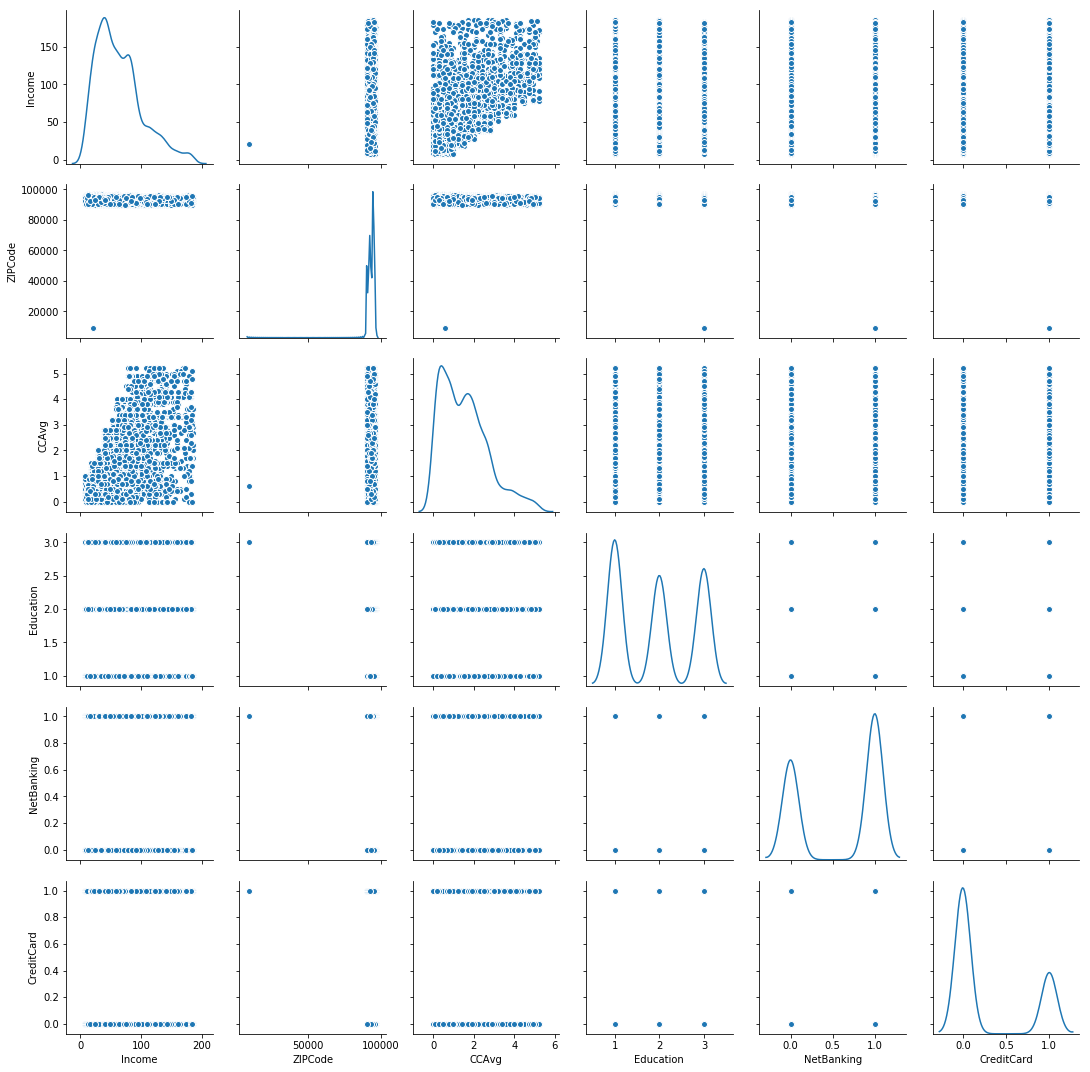

In [762]:
# Lets split dependant & indepenadant variables
dv = bpl_corr['PersonalLoan']
iv = bpl_corr.drop('PersonalLoan',axis=1)

# Scatter Plot of Independant Variables
sns.pairplot(iv, diag_kind='kde')

### Observations

The continuous variables Income & CCAvg distribution is not normal, hence lets normalize it  
The ZIPCode doesn't have any relation, hence drop the ZIPCode

## Model the data using Logistic Regression and KNN

### Model without Normalizaing the distribution

In [763]:
# Use the data where consumers accepted Personal Loan for training Logistic Regression
# It's important to ensure that the train/test data has equal proportion of consumers who accepted personal Loan
iv_train,iv_test,dv_train,dv_test=train_test_split(iv, dv, train_size=0.8, random_state=1,stratify=y)
iv_train.shape

(3518, 6)

In [764]:
# As we need to use the previous campaign's customer behavior, let's ensure the split of accepted personal loan's 
# is evenly distributed between train & test set
print("Distribution Percentage of previous campaign data\n{}".format((dv_train.value_counts()/dv.value_counts())))

Distribution Percentage of previous campaign data
0    0.800000
1    0.798535
Name: PersonalLoan, dtype: float64


In [765]:
model = LogisticRegression()
model.fit(iv_train, dv_train)

# Train Set Scores
dv_predict = model.predict(iv_train)
model_score = model.score(iv_train, dv_train)
print(model_score)
print(confusion_matrix(dv_train, dv_predict))
print("Train Set: Accuracy Score = {}, F1 Score = {}\n\n".format(accuracy_score(dv_train,dv_predict),
                                                                 f1_score(dv_train,dv_predict)))

# Test Set Scores
dv_predict = model.predict(iv_test)
model_score = model.score(iv_test, dv_test)
print(model_score)
print(confusion_matrix(dv_test, dv_predict))
print("Test Set: Accuracy Score = {}, F1 Score = {}".format(accuracy_score(dv_test,dv_predict),
                                                            f1_score(dv_test,dv_predict)))

0.9400227401932917
[[3255   45]
 [ 166   52]]
Train Set: Accuracy Score = 0.940022740193, F1 Score = 0.330158730159


0.9386363636363636
[[810  15]
 [ 39  16]]
Test Set: Accuracy Score = 0.938636363636, F1 Score = 0.372093023256


### Observations

1. We get Accurancy of 94% only & Low F1 Score

### Model the same with KNN

In [766]:
# Lets try with KNN Model
kList = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 31, 33, 35, 37, 39, 41]
scores = []
# Perform Cross Validation
for k in kList:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores.append(cross_val_score(knn, iv_train, dv_train, cv=10, scoring='accuracy').mean())
scores

[0.9164246632996633,
 0.9283661939911939,
 0.9374643874643874,
 0.9368962056462056,
 0.9394546425796427,
 0.9368970150220151,
 0.9368970150220151,
 0.9360439329189327,
 0.9380333786583787,
 0.9391705516705517,
 0.938034188034188,
 0.9383182789432789,
 0.9383182789432789,
 0.938034188034188,
 0.9386031792281792,
 0.9380349974099973,
 0.938034188034188,
 0.937750097125097,
 0.937750097125097,
 0.937750097125097]

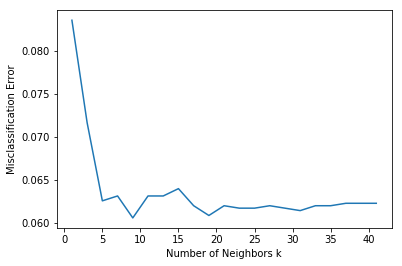

In [767]:
scores_err = [1 - x for x in scores]
# plot misclassification error vs k
plt.plot(kList, scores_err)
plt.xlabel('Number of Neighbors k')
plt.ylabel('Misclassification Error')
plt.show()

### Observations

The accuracy of KNN is almost same as Logistic Regression ~ 94% with Optimal Neighbours as 9

### Model by removing ZIPCode but not normalizing the distribution

### Logistic Regression

In [768]:
iv = bpl_corr.drop(['PersonalLoan','ZIPCode'],axis=1)

In [769]:
iv_train,iv_test,dv_train,dv_test=train_test_split(iv, dv, train_size=0.8, random_state=1,stratify=dv)
model = LogisticRegression()
model.fit(iv_train, dv_train)

# Train Set Scores
dv_predict = model.predict(iv_train)
model_score = model.score(iv_train, dv_train)
print(model_score)
print(confusion_matrix(dv_train, dv_predict))
print("Train Set: Accuracy Score = {}, F1 Score = {}\n\n".format(accuracy_score(dv_train,dv_predict),
                                                                 f1_score(dv_train,dv_predict)))

# Test Set Scores
dv_predict = model.predict(iv_test)
model_score = model.score(iv_test, dv_test)
print(model_score)
print(confusion_matrix(dv_test, dv_predict))
print("Test Set: Accuracy Score = {}, F1 Score = {}".format(accuracy_score(dv_test,dv_predict),
                                                            f1_score(dv_test,dv_predict)))

0.9610574189880614
[[3281   19]
 [ 118  100]]
Train Set: Accuracy Score = 0.961057418988, F1 Score = 0.593471810089


0.9568181818181818
[[818   7]
 [ 31  24]]
Test Set: Accuracy Score = 0.956818181818, F1 Score = 0.558139534884


### Observations

The accuracy score improved to ~96% with improved F1 score as well  
Hence the conclusion is that removing ZIPCode is not helping in prediction of PersonalLoan instead it skews the data

### KNN Model

In [770]:
# Lets try with KNN Model
kList = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 31, 33, 35, 37, 39, 41]
scores = []
# Perform Cross Validation
for k in kList:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores.append(cross_val_score(knn, iv_train, dv_train, cv=10, scoring='accuracy').mean())
scores

[0.9559456746956748,
 0.9585000647500648,
 0.9593507187257189,
 0.9576461732711733,
 0.9556567275317274,
 0.9545187451437451,
 0.9522452084952086,
 0.9505406630406629,
 0.9482679357679358,
 0.9462776806526808,
 0.9457086894586896,
 0.9448564167314167,
 0.9440041440041439,
 0.944004144004144,
 0.9428653522403522,
 0.943433534058534,
 0.9434343434343434,
 0.9431502525252526,
 0.9425820707070708,
 0.9434343434343434]

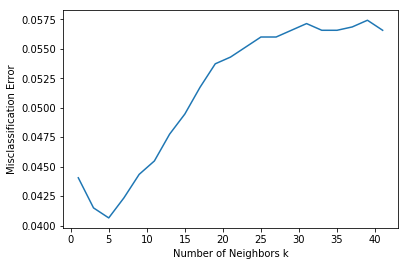

In [771]:
scores_err = [1 - x for x in scores]
# plot misclassification error vs k
plt.plot(kList, scores_err)
plt.xlabel('Number of Neighbors k')
plt.ylabel('Misclassification Error')
plt.show()

###### Observations

The KNN Model accuracy is minimally improved to 96% and Optimal Neighbours is 5  
Removing ZIPCode really impacted KNN Model accuracy

## Normalize the Distribution and Rerun the Models

(array([672., 947., 770., 611., 648., 259., 187., 143.,  80.,  81.]),
 array([  8. ,  25.7,  43.4,  61.1,  78.8,  96.5, 114.2, 131.9, 149.6,
        167.3, 185. ]),
 <a list of 10 Patch objects>)

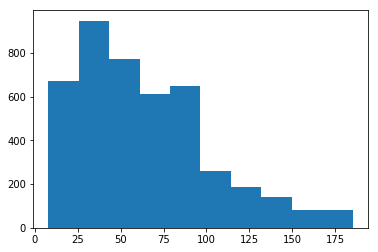

In [772]:
# Reset Independant Variable back to Original Values
iv = bpl_corr.drop(['PersonalLoan','ZIPCode'],axis=1)
plt.hist(iv['Income'])

(array([1039.,  812.,  569.,  700.,  481.,  370.,  135.,  130.,   81.,
          81.]),
 array([0.        , 0.51999998, 1.03999996, 1.55999994, 2.07999992,
        2.5999999 , 3.11999989, 3.63999987, 4.15999985, 4.67999983,
        5.19999981]),
 <a list of 10 Patch objects>)

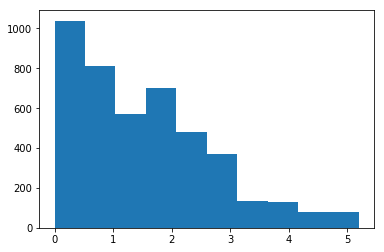

In [773]:
plt.hist(iv['CCAvg'])

In [774]:
# Use Z-Score to transform
iv['Income'] = (iv['Income']-iv['Income'].mean())/iv['Income'].std()
iv['CCAvg'] = (iv['CCAvg']-iv['CCAvg'].mean())/iv['CCAvg'].std()

(array([672., 947., 770., 611., 648., 259., 187., 143.,  80.,  81.]),
 array([-1.4749535 , -1.00946592, -0.54397835, -0.07849078,  0.3869968 ,
         0.85248437,  1.31797195,  1.78345952,  2.24894709,  2.71443467,
         3.17992224]),
 <a list of 10 Patch objects>)

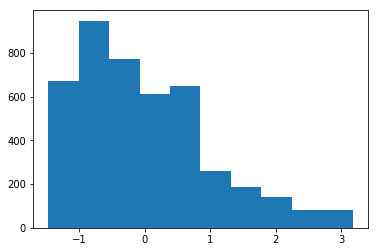

In [775]:
plt.hist(iv['Income'])

(array([1039.,  812.,  569.,  700.,  481.,  370.,  135.,  130.,   81.,
          81.]),
 array([-1.34003508, -0.89080614, -0.4415772 ,  0.00765175,  0.45688069,
         0.90610963,  1.35533857,  1.80456752,  2.25379646,  2.7030254 ,
         3.15225434]),
 <a list of 10 Patch objects>)

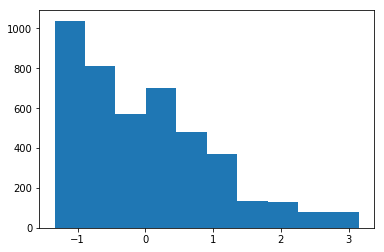

In [776]:
plt.hist(iv['CCAvg'])

### Logistic Regression

In [777]:
iv_train,iv_test,dv_train,dv_test=train_test_split(iv, dv, train_size=0.8, random_state=1,stratify=dv)
model = LogisticRegression()
model.fit(iv_train, dv_train)

# Train Set Scores
dv_predict = model.predict(iv_train)
model_score = model.score(iv_train, dv_train)
print(model_score)
print(confusion_matrix(dv_train, dv_predict))
print("Train Set: Accuracy Score = {}, F1 Score = {}\n\n".format(accuracy_score(dv_train,dv_predict),
                                                                 f1_score(dv_train,dv_predict)))

# Test Set Scores
dv_predict = model.predict(iv_test)
model_score = model.score(iv_test, dv_test)
print(model_score)
print(confusion_matrix(dv_test, dv_predict))
print("Test Set: Accuracy Score = {}, F1 Score = {}".format(accuracy_score(dv_test,dv_predict),
                                                            f1_score(dv_test,dv_predict)))

0.9627629334849346
[[3277   23]
 [ 108  110]]
Train Set: Accuracy Score = 0.962762933485, F1 Score = 0.626780626781


0.9568181818181818
[[817   8]
 [ 30  25]]
Test Set: Accuracy Score = 0.956818181818, F1 Score = 0.568181818182


### Observations

No big change in Accuracy after using zscore. 
Accuracy is 96.3%

### KNN Model

In [778]:
# Lets try with KNN Model
kList = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 31]
scores = []
# Perform Cross Validation
for k in kList:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores.append(cross_val_score(knn, iv_train, dv_train, cv=10, scoring='accuracy').mean())
scores

[0.9656023374773375,
 0.9698709854959855,
 0.9712914400414402,
 0.9701534576534575,
 0.9701542670292669,
 0.9695844664594665,
 0.9693003755503755,
 0.9678791116291116,
 0.9667419386169387,
 0.9678791116291116,
 0.966742747992748,
 0.96759583009583,
 0.9678799210049209,
 0.9667435573685573,
 0.9658912846412845]

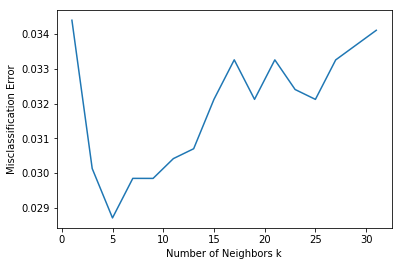

In [779]:
scores_err = [1 - x for x in scores]
# plot misclassification error vs k
plt.plot(kList, scores_err)
plt.xlabel('Number of Neighbors k')
plt.ylabel('Misclassification Error')
plt.show()

### Observations:

Optimal Neighbour = 7  
Accuracy: 97%

KNN Yield better accuracy rate with z-score based distribution  
With Optimial Neighbour of 5, the misclassification error is at the lowest

## Other Distribution Models (BoxCox, ...)

### BoxCox

(array([672., 640., 557., 358., 377., 337., 485., 222., 259., 491.]),
 array([0.07011252, 0.16302761, 0.2559427 , 0.34885779, 0.44177288,
        0.53468798, 0.62760307, 0.72051816, 0.81343325, 0.90634834,
        0.99926343]),
 <a list of 10 Patch objects>)

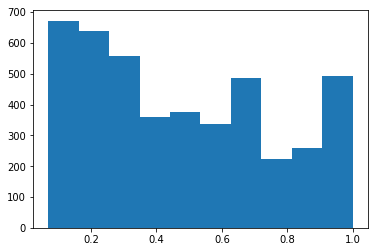

In [780]:
# Reset Independant Variable back to Original Values
iv = bpl_corr.drop(['PersonalLoan','ZIPCode'],axis=1)

# Transform income using boxcox
# We can't use boxcox with CCAvg as it has zero values
iv['Income'] = stats.boxcox(iv['Income'],0)
plt.hist(no_corr['Income'])

In [781]:
iv_train,iv_test,dv_train,dv_test=train_test_split(iv, dv, train_size=0.8, random_state=1,stratify=dv)
model = LogisticRegression()
model.fit(iv_train, dv_train)

# Train Set Scores
dv_predict = model.predict(iv_train)
model_score = model.score(iv_train, dv_train)
print(model_score)
print(confusion_matrix(dv_train, dv_predict))
print("Train Set: Accuracy Score = {}, F1 Score = {}\n\n".format(accuracy_score(dv_train,dv_predict),
                                                                 f1_score(dv_train,dv_predict)))

# Test Set Scores
dv_predict = model.predict(iv_test)
model_score = model.score(iv_test, dv_test)
print(model_score)
print(confusion_matrix(dv_test, dv_predict))
print("Test Set: Accuracy Score = {}, F1 Score = {}".format(accuracy_score(dv_test,dv_predict),
                                                            f1_score(dv_test,dv_predict)))

0.9491188175099489
[[3298    2]
 [ 177   41]]
Train Set: Accuracy Score = 0.94911881751, F1 Score = 0.314176245211


0.9488636363636364
[[825   0]
 [ 45  10]]
Test Set: Accuracy Score = 0.948863636364, F1 Score = 0.307692307692


### KNN Model

In [782]:
# Lets try with KNN Model
kList = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 31]
scores = []
# Perform Cross Validation
for k in kList:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores.append(cross_val_score(knn, iv_train, dv_train, cv=10, scoring='accuracy').mean())
scores

[0.9661737567987568,
 0.9667435573685573,
 0.9630479474229474,
 0.9576510295260295,
 0.9590706746956748,
 0.9579343110593109,
 0.9570796102046101,
 0.9559424371924372,
 0.9562289562289562,
 0.9550925925925926,
 0.9553766835016834,
 0.9553758741258742,
 0.955659965034965,
 0.9525341556591558,
 0.9525333462833464]

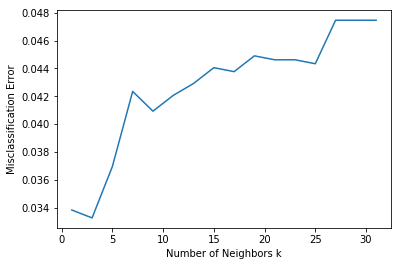

In [783]:
scores_err = [1 - x for x in scores]
# plot misclassification error vs k
plt.plot(kList, scores_err)
plt.xlabel('Number of Neighbors k')
plt.ylabel('Misclassification Error')
plt.show()

### Observations
Logistic Regression Yielded Poor Accuracy with 94.9%
KNN Yielded better accuracy with 96.7 & Optimal Neighbour of 3

### p-Value based

In [784]:
# Reset Independant Variable back to Original Values
iv = bpl_corr.drop(['PersonalLoan','ZIPCode'],axis=1)

# Transform
iv['Income'] = stats.norm.cdf(iv['Income'],iv['Income'].mean(),iv['Income'].std())
iv['CCAvg'] = stats.norm.cdf(iv['CCAvg'],iv['CCAvg'].mean(),iv['CCAvg'].std())

### Logistic Regression

In [785]:
iv_train,iv_test,dv_train,dv_test=train_test_split(iv, dv, train_size=0.8, random_state=1,stratify=dv)
model = LogisticRegression()
model.fit(iv_train, dv_train)

# Train Set Scores
dv_predict = model.predict(iv_train)
model_score = model.score(iv_train, dv_train)
print(model_score)
print(confusion_matrix(dv_train, dv_predict))
print("Train Set: Accuracy Score = {}, F1 Score = {}\n\n".format(accuracy_score(dv_train,dv_predict),
                                                                 f1_score(dv_train,dv_predict)))

# Test Set Scores
dv_predict = model.predict(iv_test)
model_score = model.score(iv_test, dv_test)
print(model_score)
print(confusion_matrix(dv_test, dv_predict))
print("Test Set: Accuracy Score = {}, F1 Score = {}".format(accuracy_score(dv_test,dv_predict),
                                                            f1_score(dv_test,dv_predict)))

0.9567936327458784
[[3298    2]
 [ 150   68]]
Train Set: Accuracy Score = 0.956793632746, F1 Score = 0.472222222222


0.9534090909090909
[[824   1]
 [ 40  15]]
Test Set: Accuracy Score = 0.953409090909, F1 Score = 0.422535211268


### KNN Model

In [786]:
# Lets try with KNN Model
kList = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 31]
scores = []
# Perform Cross Validation
for k in kList:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores.append(cross_val_score(knn, iv_train, dv_train, cv=10, scoring='accuracy').mean())
scores

[0.9602013727013727,
 0.9667443667443669,
 0.9661761849261848,
 0.9670284576534577,
 0.9670308857808857,
 0.9684497215747216,
 0.9670308857808857,
 0.964754921004921,
 0.9644700207200207,
 0.9604911292411293,
 0.9582175925925925,
 0.95736531986532,
 0.9573645104895105,
 0.9579343110593111,
 0.9570804195804197]

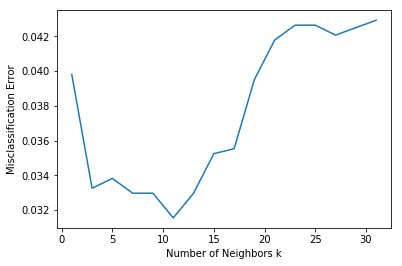

In [787]:
scores_err = [1 - x for x in scores]
# plot misclassification error vs k
plt.plot(kList, scores_err)
plt.xlabel('Number of Neighbors k')
plt.ylabel('Misclassification Error')
plt.show()

### Observations
With p-value based distribution also KNN Model yielded better accuracy of 96.8% with optimal neighbour of 11

# Conclusion

With Z Score & removing outliers the accuracy considerably improved  
KNN Model gave the better accuracy & the max of 97%  

The Personal Loan is dependant on Income, CreditCard Average Spending, Education, Use of InternetBanking & Holding a CreditCard  

Based on the previous campaign, it's found that the consumers with the following attributes are more likely to   
accept the personal loan:
1. Higher income, Higher credit card spend were most likely to accept the personal loand
2. Consumers who have Education with Advanced/Professional has higher probability
3. Holding Credit Card and Perfom Online Banking

# Thank You